# Cusotmer Segmentation with K-means

## Workflow
- Load data and EDA
- Preprocessing
- Choose K (Elbows and Silhoutte)
- Train KMeans
- Visualiza with PCA (2D and 3D)
- Clsuter profiling (means and heatmap)
- Export results

In [20]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

#visualization set up

plt.style.use("seaborn-v0_8")
sns.set(context="notebook", style="whitegrid")
RANDOM_STATE = 42

In [21]:
#LOAD DATASET

cust_seg = "Mall_Customers.csv"
df = pd.read_csv(cust_seg)
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [22]:
# Comulns normalization

col_map = {
    "Genre" : "Gender",
    "Annual Income (k$)" : "AnnualIncome",
    "Spending Score (1-100)" : "SpendingScore"
}

df = df.rename(columns=col_map)



In [23]:
#Dataset information

print("/n === Head ===")
print(df.head())

print("/n === Info ===")
print(df.info())

print('/n === Describe ===')
print(df.describe())


/n === Head ===
   CustomerID  Gender  Age  AnnualIncome  SpendingScore
0           1    Male   19            15             39
1           2    Male   21            15             81
2           3  Female   20            16              6
3           4  Female   23            16             77
4           5  Female   31            17             40
/n === Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   CustomerID     200 non-null    int64 
 1   Gender         200 non-null    object
 2   Age            200 non-null    int64 
 3   AnnualIncome   200 non-null    int64 
 4   SpendingScore  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
None
/n === Describe ===
       CustomerID         Age  AnnualIncome  SpendingScore
count  200.000000  200.000000    200.000000     200.000000
mean   100.500000   38.850000     

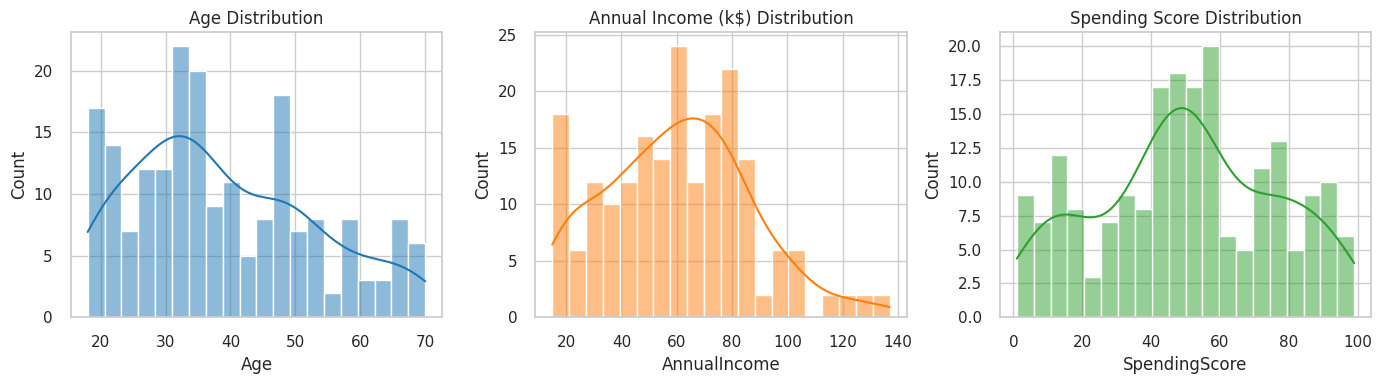

In [25]:
# EDA

fig, axes = plt.subplots (1, 3, figsize = (14, 4))
sns.histplot(df["Age"], bins=20, kde=True, ax=axes[0], color = "#1f77b4")
axes[0].set_title("Age Distribution")
sns.histplot(df["AnnualIncome"], bins=20, kde=True, ax=axes[1], color = "#ff7f0e")
axes[1].set_title("Annual Income (k$) Distribution")
sns.histplot(df["SpendingScore"], bins = 20, kde=True, ax=axes[2], color = "#2ca02c")
axes[2].set_title("Spending Score Distribution")
plt.tight_layout()
plt.show()

In [27]:
# Preprocesing

if "Gender" in df.columns:
  df["GenderNum"] = df["Gender"].map({"Male": 1, "Female":0})
else:
  df["GenderNum"] = np.nan #if not gender info, keep NaN

features = ["Age", "AnnualIncome", "SpendingScore"]
X = df[features].copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)#calculate mean and SD, data standardization

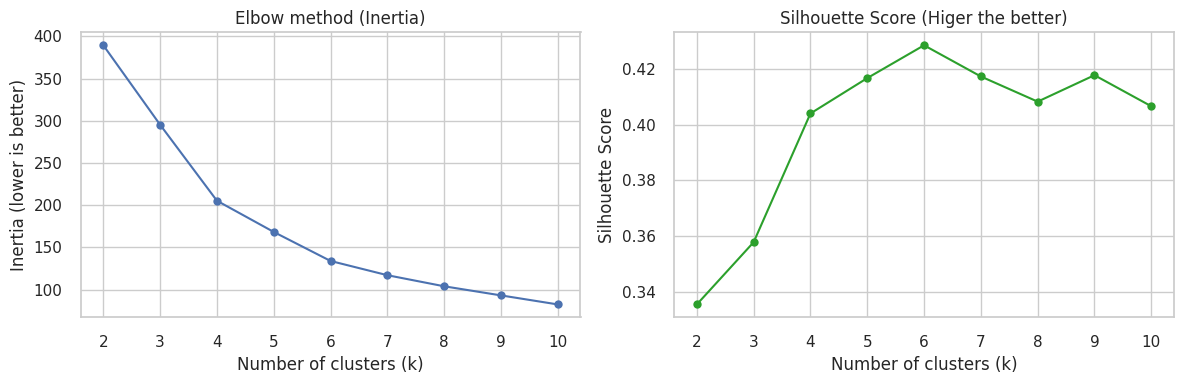


 Suggested K by soilhouette: 6


In [29]:
#chosing number of clusters (K)

inertias = []
silhouettes = []
k_values = list(range(2,11)) #avoid k=1 for silhouette

for K in k_values:
  km = KMeans(n_clusters=K, random_state=RANDOM_STATE, n_init=10)
  km.fit(X_scaled)
  inertias.append(km.inertia_)
  labels = km.labels_
  silhouettes.append (silhouette_score(X_scaled, labels))

# Move plotting and best_k calculation outside the loop
fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].plot(k_values, inertias, marker = "o")
ax[0].set_title("Elbow method (Inertia)")
ax[0].set_xlabel("Number of clusters (k)")
ax[0].set_ylabel("Inertia (lower is better)")

ax[1].plot(k_values, silhouettes, marker = "o", color = "#2ca02c")
ax[1].set_title("Silhouette Score (Higer the better)")
ax[1].set_xlabel("Number of clusters (k)")
ax[1].set_ylabel("Silhouette Score")
plt.tight_layout()
plt.show()

best_k = k_values[int(np.argmax(silhouettes))]
print(f"\n Suggested K by soilhouette: {best_k}")

In [31]:
# Trian K-Means with selected K

kmeans = KMeans(n_clusters = best_k, random_state=RANDOM_STATE, n_init = 10)
kmeans.fit(X_scaled)
df["Cluster"] = kmeans.labels_

#CLuster centers
centers_scaled = kmeans.cluster_centers_
centers = scaler.inverse_transform(centers_scaled)
center_df = pd.DataFrame(centers, columns=features)
center_df['Cluster'] = range(best_k)

print("\n === Clusters centers (units) ===")
print(center_df)


 === Clusters centers (units) ===
         Age  AnnualIncome  SpendingScore  Cluster
0  56.333333     54.266667      49.066667        0
1  26.794872     57.102564      48.128205        1
2  41.939394     88.939394      16.969697        2
3  32.692308     86.538462      82.128205        3
4  25.000000     25.260870      77.608696        4
5  45.523810     26.285714      19.380952        5


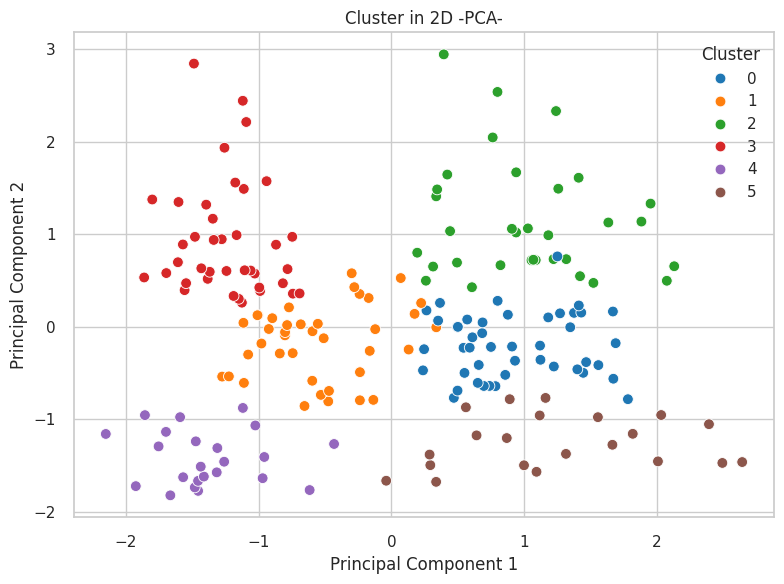

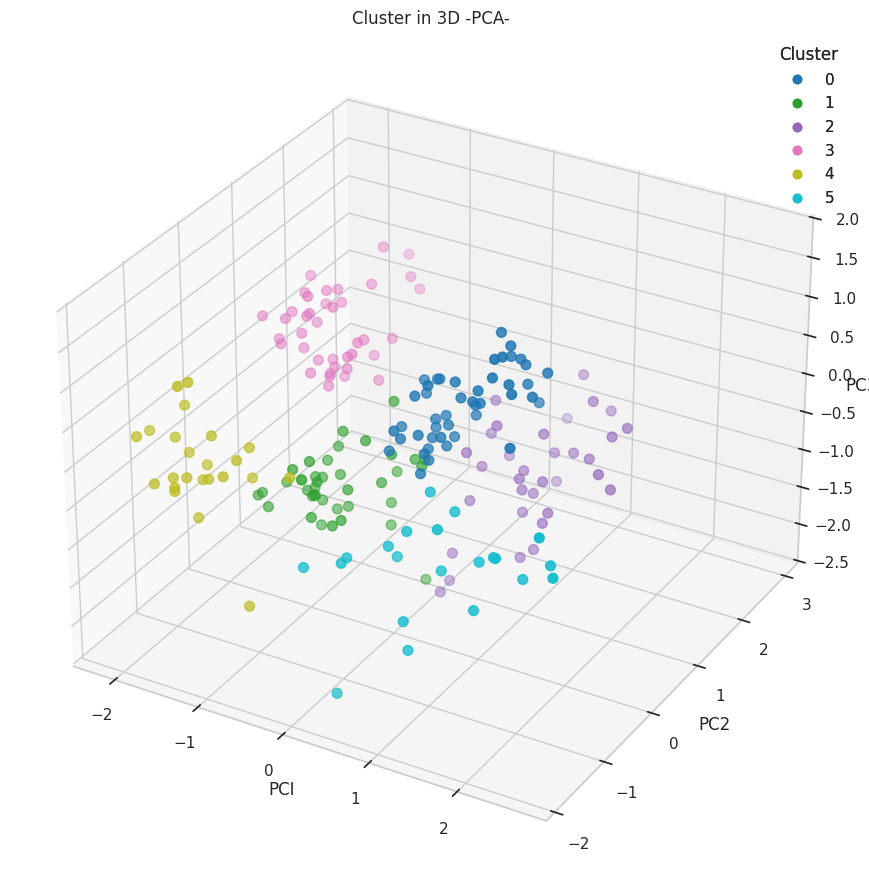

In [35]:
# PCA Visualizations

pca = PCA(n_components = 2, random_state = RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)
df['PCA1'] = X_pca[:, 0]
df['PCA2'] = X_pca[:, 1]

plt.figure(figsize = (8,6))
sns.scatterplot(
    data = df,
    x = 'PCA1',
    y = 'PCA2',
    hue = 'Cluster',
    palette = 'tab10',
    s=60
)

plt.title('Cluster in 2D -PCA-')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title = "Cluster")
plt.tight_layout()
plt.show()

# 3D PCA with matplotlib

try:
  from mpl_toolkits.mplot3d import Axes3D
  pca3 = PCA(n_components = 3, random_state = RANDOM_STATE)
  X_pca3 = pca3.fit_transform(X_scaled)

  fig = plt.figure(figsize = (12, 9))
  ax = fig.add_subplot(111, projection="3d")
  scatter = ax.scatter(
      X_pca3[:, 0],
      X_pca3[:, 1],
      X_pca3[:, 2],
      c = df["Cluster"],
      cmap = "tab10",
      s=50
  )

  ax.set_title("Cluster in 3D -PCA-")
  ax.set_xlabel("PCI")
  ax.set_ylabel("PC2")
  ax.set_zlabel("PC3")

  legend1 = ax.legend(*scatter.legend_elements(), title = "Cluster")
  ax.add_artist(legend1)
  plt.tight_layout()
  plt.show()
except Exception as e:
  print("\n3D PCA plot skipped. Reason:", e)



 === Average profile per Cluster ===
          Age  AnnualIncome  SpendingScore  N_customers
Cluster                                                
0        56.3          54.3           49.1           45
1        26.8          57.1           48.1           39
2        41.9          88.9           17.0           33
3        32.7          86.5           82.1           39
4        25.0          25.3           77.6           23
5        45.5          26.3           19.4           21


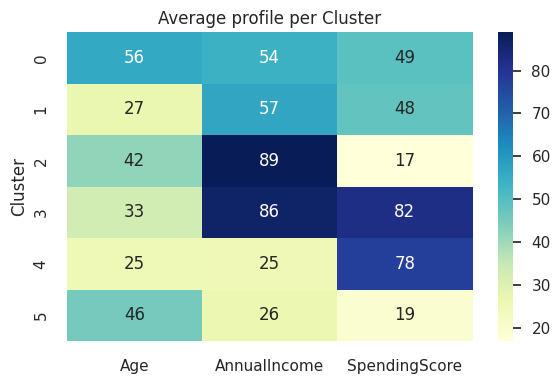

In [38]:
#Cluster profiling
# - Mean values per cluster for understanding
# - Heatmap for understanding

profile = df.groupby("Cluster")[features].mean().round(1)
count = df.groupby("Cluster")["CustomerID"].count() if 'CustomerID' in df.columns else df.groupby('Cluster').size()
profile["N_customers"] = count

print("\n === Average profile per Cluster ===")
print(profile)

#Heatmap
plt.figure(figsize = (6,4))
sns.heatmap(profile[features], annot = True, cmap = "YlGnBu")
plt.title("Average profile per Cluster")
plt.tight_layout()
plt.show()

# Conclusion

The analysis successfully segmented the customers into 6 distinct groups based on their age, annual income, and spending score. Each cluster exhibits a unique profile, which can be invaluable for targeted marketing strategies, personalized promotions, and improved customer relationship management.